# Time Series of YCSD Covid Case Metric

This notebook examines the time series of the York County COVID Cases ostensibly used by YCSD to make decisions about school reopenings.

* YCSD presents there metrics on https://ycsd.yorkcountyschools.org/domain/1313
* VDH represents the this number for the localities on https://www.vdh.virginia.gov/coronavirus/coronavirus/covid-19-in-virginia-locality/ and on https://www.vdh.virginia.gov/coronavirus/key-measures/pandemic-metrics/school-metrics/ under the localities tab
* VDH shares the data at https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr
* I'm sharing This notebook in Github at https://github.com/drf5n/YCSD_covid_metrics and https://github.com/drf5n/YCSD_covid_metrics/blob/master/YorkCountyCovidMetric.ipynb
* CDC has https://beta.healthdata.gov/Community/COVID-19-State-Profile-Report-Virginia/3ghy-svgi 

-- David Forrest 2020-12-04


In [1]:
# %matplotlib widget
import os,sys,io, time, datetime, pathlib
import pandas as pd
#import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt

import bokeh.plotting
import bokeh.io
import bokeh.models
from bokeh.io import output_notebook
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
def file_age(filepath):
    return time.time() - os.path.getmtime(filepath)


In [20]:
# get the Virginia COVID Case data from https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr

df_name = "VA_vdh_casedata.csv"

df=pd.read_csv(df_name)
#display(datetime.datetime.now() - pd.to_datetime(df['Report Date'].iloc[-1])   )
#display(datetime.datetime.now() - pd.to_datetime(df['Report Date'].iloc[-1])  > datetime.timedelta(days=1) )

#if 1 or file_age(df_name) > 86400/2:
if not os.path.exists(df_name) or (datetime.datetime.now() - pd.to_datetime(df['Report Date'].iloc[-1])  > datetime.timedelta(days=1)) :
    !wget -O $df_name 'https://data.virginia.gov/api/views/bre9-aqqr/rows.csv?accessType=DOWNLOAD'
    pathlib.Path(df_name).touch()
df=pd.read_csv(df_name)
df["date"] = pd.to_datetime(df['Report Date'])
last_date = df['date'].iloc[-1]

if ((datetime.datetime.now() - last_date).days  >= 1) :
    display(f"{df_name} is still old with {last_date} versus {datetime.datetime.now()}")
else:
    display(f"{df_name} is up to date at {last_date} versus {datetime.datetime.now()}")

--2021-02-18 16:14:40--  https://data.virginia.gov/api/views/bre9-aqqr/rows.csv?accessType=DOWNLOAD
Resolving data.virginia.gov (data.virginia.gov)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.virginia.gov (data.virginia.gov)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘VA_vdh_casedata.csv’

VA_vdh_casedata.csv     [    <=>             ]   2.11M  2.64MB/s    in 0.8s    

2021-02-18 16:14:41 (2.64 MB/s) - ‘VA_vdh_casedata.csv’ saved [2216482]



'VA_vdh_casedata.csv is up to date at 2021-02-18 00:00:00 versus 2021-02-18 16:14:42.030399'

In [4]:

df = df.sort_values(by=['Locality', 'date'])

df['TC_diff']= df.groupby('Locality')['Total Cases'].diff().fillna(0)
df['TC_sum14']= df.groupby('Locality')['Total Cases'].diff(14).fillna(0)

display(df.head())
display(df.tail())


,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date,TC_diff,TC_sum14
897,03/17/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-17,0.0,0.0
1030,03/18/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-18,0.0,0.0
1163,03/19/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-19,0.0,0.0
1296,03/20/2020,51001,Accomack,Eastern Shore,1,0,0,2020-03-20,1.0,0.0
1429,03/21/2020,51001,Accomack,Eastern Shore,1,0,0,2020-03-21,0.0,0.0


,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date,TC_diff,TC_sum14
44383,02/13/2021,51199,York,Peninsula,2809,48,21,2021-02-13,19.0,275.0
44524,02/14/2021,51199,York,Peninsula,2832,48,21,2021-02-14,23.0,284.0
44649,02/15/2021,51199,York,Peninsula,2840,48,21,2021-02-15,8.0,281.0
44782,02/16/2021,51199,York,Peninsula,2849,49,22,2021-02-16,9.0,275.0
44915,02/17/2021,51199,York,Peninsula,2872,49,22,2021-02-17,23.0,280.0


In [5]:
# Read VDH population data donwloaded from https://apps.vdh.virginia.gov/HealthStats/stats.htm 
# and https://apps.vdh.virginia.gov/HealthStats/documents/xls/2018%20Pop.xls 

pop_file = '/Users/drf/Downloads/2018 Pop.xls'
if not os.path.exists(pop_file):
    ! wget -O "$pop_name" https://apps.vdh.virginia.gov/HealthStats/documents/xls/2018%20Pop.xls

popxls=pd.read_excel('/Users/drf/Downloads/2018 Pop.xls',header=[3])
popxls['FIPS']=51000+(popxls.loc[:,'Code'].fillna(0)).astype(int)  # eliminate NaNs above?
#display(popxls[popxls['Code']==199]['Population'])
#display(popxls['Locality'].str.match('York County').fillna(False))
display(popxls[popxls['Locality'].str.match('York County').fillna(False)])
display(popxls[popxls['Locality'].str.contains('Virginia Beach').fillna(False)])
#display("City:",popxls[popxls['Locality'].str.contains('City').fillna(False)])



,Code,Region,District,Locality,Population,0,1-4,5-9,10-14,15-17,...,20-24.1,25-34,35-44,45-54,55-64,65-74,75-84,85+,0,FIPS
126,199.0,5.0,21.0,York County ...,67846.0,640.0,3151.0,4480.0,4823.0,3062.0,...,4240.0,7876.0,8869.0,8805.0,9284.0,6311.0,3428.0,1218.0,640.0,51199


,Code,Region,District,Locality,Population,0,1-4,5-9,10-14,15-17,...,20-24.1,25-34,35-44,45-54,55-64,65-74,75-84,85+,0,FIPS
124,810.0,5.0,20.0,Virginia Beach City ...,450189.0,5609.0,22638.0,27497.0,27714.0,16115.0,...,31409.0,74440.0,59481.0,55457.0,55664.0,37719.0,18653.0,7632.0,5609.0,51810


In [6]:
# subset for York and normalize per capita
loi='York'

VDH_pop = int(popxls[popxls['Locality'].str.match('York').fillna(False)]['Population'])
display("VDH_pop: ",VDH_pop)


dfy = df[df['Locality']=='York'].copy()
dfy['per100k_14daysum']=dfy['TC_sum14']*100000/68280  
dfy['per100k_14daysum']=dfy['TC_sum14']*100000/VDH_pop



# for VB:

if 0:
    loi='Virginia Beach'

    dfy = df[df['Locality']=='Virginia Beach'].copy()
    dfy['per100k_14daysum']=dfy['TC_sum14']*100000/450189  


'VDH_pop: '

67846

In [7]:
dfy.tail(30)

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date,TC_diff,TC_sum14,per100k_14daysum
41058,01/19/2021,51199,York,Peninsula,2099,38,13,2021-01-19,22.0,465.0,685.375704
41191,01/20/2021,51199,York,Peninsula,2137,38,13,2021-01-20,38.0,476.0,701.588892
41324,01/21/2021,51199,York,Peninsula,2175,39,15,2021-01-21,38.0,474.0,698.641040
41457,01/22/2021,51199,York,Peninsula,2198,40,15,2021-01-22,23.0,469.0,691.271409
41509,01/23/2021,51199,York,Peninsula,2253,41,16,2021-01-23,55.0,496.0,731.067417
41723,01/24/2021,51199,York,Peninsula,2287,41,16,2021-01-24,34.0,486.0,716.328155
41856,01/25/2021,51199,York,Peninsula,2347,41,16,2021-01-25,60.0,504.0,742.858827
41989,01/26/2021,51199,York,Peninsula,2397,41,16,2021-01-26,50.0,511.0,753.176311
42122,01/27/2021,51199,York,Peninsula,2448,41,16,2021-01-27,51.0,549.0,809.185508
42255,01/28/2021,51199,York,Peninsula,2485,41,16,2021-01-28,37.0,566.0,834.242255


<AxesSubplot:title={'center':'York County Number of new cases per 100,000 persons \nwithin the last 14 days'}, xlabel='date'>

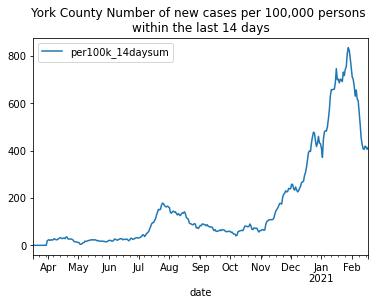

In [8]:
ph = dfy.plot(y='per100k_14daysum',x='date',title="York County Number of new cases per 100,000 persons \nwithin the last 14 days")

ph

<AxesSubplot:title={'center':'York County Cases, 14 day sum, per 100K'}, xlabel='date'>

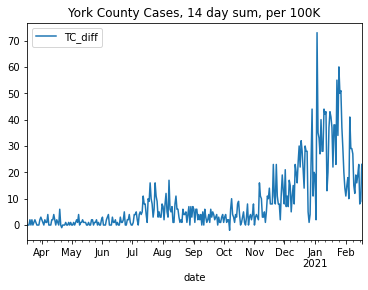

In [9]:
ph = dfy.plot(y='TC_diff',x='date',title="York County Cases, 14 day sum, per 100K")
ph

In [10]:
TOOLTIPS = [
 #   ("index", "$index"),
 #   ("date:", "$x{%F %T}"),
    ("date:", "@date{%F}"),
    ("cases/14d/100k:","@per100k_14daysum"),
 #   ("(x,y)", "($x, $y)"),
]

vmax = (int(dfy['per100k_14daysum'].max() / 40 )+2)*40 # 

per100k_14daysum=bokeh.plotting.figure( tooltips=TOOLTIPS, x_axis_type='datetime')
p=bokeh.plotting.figure( x_axis_type='datetime',y_range=(0,vmax),
#                        tooltips=TOOLTIPS,formatters={"$x": "datetime"},
                        title="{} Number of new cases per 100,000 persons within the last 14 days".format(loi))

p.add_layout(bokeh.models.Title(
    text="Code: https://github.com/drf5n/YCSD_covid_metrics", text_font_style="italic"), 'above')

p.add_layout(bokeh.models.Title(
    text="https://drf5n.github.io/YCSD_covid_metrics/YorkCountyCovidMetric_plot.html", text_font_style="italic"), 'above')


hth = bokeh.models.HoverTool(tooltips=TOOLTIPS,
                             formatters={"$x": "datetime",
                                        "@date": "datetime"
                                        },
                             mode='vline',
                            )

print(hth)
print(hth.formatters)
p.add_tools(hth)
#hover = p.select(dict(type=bokeh.models.HoverTool))


#hover(tooltips=TOOLTIPS,
#)

p.add_layout(bokeh.models.BoxAnnotation(bottom=0,top=5, fill_alpha=0.4, fill_color='teal'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=5,top=20, fill_alpha=0.4, fill_color='lightgreen'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=20,top=50, fill_alpha=0.4, fill_color='yellow'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=50,top=200, fill_alpha=0.4, fill_color='orange'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=200, fill_alpha=0.4, fill_color='red'))



#p.line(dfy['date'],dfy['per100k_14daysum'])
p.line(x='date', y='per100k_14daysum',source=dfy)
#p.title()

#?p.line

HoverTool(id='1070', ...)
{'$x': 'datetime', '@date': 'datetime'}


GlyphRenderer(id='1081', ...)

In [11]:
bokeh.plotting.show(p)

In [12]:
bokeh.plotting.output_file('docs/YorkCountyCovidMetric_plot.html', mode='inline')
bokeh.plotting.save(p)

# needs geckodriver  -- have it in conda env py3plot
bokeh.io.export_png(p, filename="docs/YorkCountyCovidMetric_plot.png")



'/Users/drf/2020/Home/School/YCSD_covid_metrics/docs/YorkCountyCovidMetric_plot.png'

In [13]:
increase=(748/56.009)
inc_days=(30+31+31)

display(increase, inc_days, increase**(1/inc_days))


13.354996518416684

92

1.0285733281314142